# Generating Text from Irish Lyrics

In [1]:
import tensorflow as tf
import numpy as np 

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [2]:
# load the dataset
# !gdown --id 15UqmiIm0xwh9mt0IYq2z3jHaauxQSTQT

In [3]:
data=open('datasets/irish-lyrics-eof.txt').read()

corpus=data.lower().split('\n')

corpus

['come all ye maidens young and fair',
 'and you that are blooming in your prime',
 'always beware and keep your garden fair',
 'let no man steal away your thyme',
 'for thyme it is a precious thing',
 'and thyme brings all things to my mind',
 'nlyme with all its flavours, along with all its joys',
 'thyme, brings all things to my mind',
 'once i and a bunch of thyme',
 'i thought it never would decay',
 'then came a lusty sailor',
 'who chanced to pass my way',
 'and stole my bunch of thyme away',
 'the sailor gave to me a rose',
 'a rose that never would decay',
 'he gave it to me to keep me reminded',
 'of when he stole my thyme away',
 'sleep, my child, and peace attend thee',
 'all through the night',
 'guardian angels god will send thee',
 'soft the drowsy hours are creeping',
 'hill and dale in slumber sleeping',
 'i my loving vigil keeping',
 'while the moon her watch is keeping',
 'while the weary world is sleeping',
 'oer thy spirit gently stealing',
 'visions of delight rev

In [4]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(corpus)
total_words=len(tokenizer.word_index) + 1 

# preprocessing the dataset

In [5]:
input_sequences=[]

for line in corpus:
    token_list=tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence=token_list[:i+1]
        input_sequences.append(n_gram_sequence)
max_sequence_length=max([len(x) for x in input_sequences])
input_sequences=pad_sequences(input_sequences,maxlen=max_sequence_length,padding='pre')
print(input_sequences[:3,:])
xs,labels=input_sequences[:,:-1],input_sequences[:,-1]
ys=tf.keras.utils.to_categorical(labels,num_classes=total_words)

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    51   12]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0   51
    12   96]
 [   0    0    0    0    0    0    0    0    0    0    0    0   51   12
    96 1217]]


In [6]:
sentences=corpus[0].split()

# sanity check

In [7]:
token_list=[]
for word in sentences:
    token_list.append(tokenizer.word_index[word])
    print(word)
token_list


come
all
ye
maidens
young
and
fair


[51, 12, 96, 1217, 48, 2, 69]

In [8]:
elem_number=5
print(xs[elem_number])
print(tokenizer.sequences_to_texts([xs[elem_number]]))

[   0    0    0    0    0    0    0    0    0   51   12   96 1217   48
    2]
['come all ye maidens young and']


In [9]:
elem_number=8
print(xs[elem_number])
print(tokenizer.sequences_to_texts([xs[elem_number]]))

[ 0  0  0  0  0  0  0  0  0  0  0  0  2 11 15]
['and you that']


# build and compile the model

In [10]:
embedding_dim=100
lstm_units=150
learning_rate=0.01

model=Sequential([
    Embedding(total_words,embedding_dim,input_length=max_sequence_length-1),
    Bidirectional(LSTM(lstm_units)),
    Dense(total_words,activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 15, 100)           269000    
                                                                 
 bidirectional (Bidirectiona  (None, 300)              301200    
 l)                                                              
                                                                 
 dense (Dense)               (None, 2690)              809690    
                                                                 
Total params: 1,379,890
Trainable params: 1,379,890
Non-trainable params: 0
_________________________________________________________________


In [11]:
epochs=100
#train the model
history=model.fit(xs,ys,epochs=epochs)

Epoch 1/100
377/377 [==============================] - 7s 9ms/step - loss: 6.6226 - accuracy: 0.0746
Epoch 2/100
377/377 [==============================] - 3s 9ms/step - loss: 5.7386 - accuracy: 0.1148
Epoch 3/100
377/377 [==============================] - 3s 8ms/step - loss: 4.8580 - accuracy: 0.1634
Epoch 4/100
377/377 [==============================] - 3s 8ms/step - loss: 3.9538 - accuracy: 0.2382
Epoch 5/100
377/377 [==============================] - 3s 9ms/step - loss: 3.1362 - accuracy: 0.3361
Epoch 6/100
377/377 [==============================] - 3s 9ms/step - loss: 2.6934 - accuracy: 0.4117
Epoch 7/100
377/377 [==============================] - 3s 9ms/step - loss: 2.9293 - accuracy: 0.3873
Epoch 8/100
377/377 [==============================] - 3s 9ms/step - loss: 2.0498 - accuracy: 0.5218
Epoch 9/100
377/377 [==============================] - 3s 9ms/step - loss: 1.6062 - accuracy: 0.6180
Epoch 10/100
377/377 [==============================] - 3s 9ms/step - loss: 1.3449 - accura

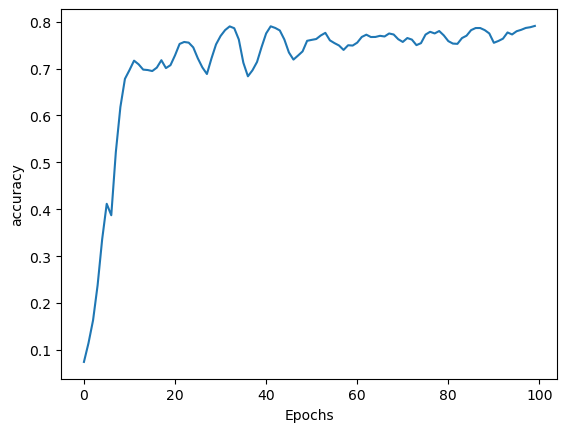

In [12]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

# Visualize the accuracy
plot_graphs(history, 'accuracy')

# generate text

In [16]:
seed_text='help me obi-wan kinobi your are my only hope'
next_word=100

for _ in range(next_word):
    token_list=tokenizer.texts_to_sequences([seed_text])[0]
    token_list=pad_sequences([token_list],maxlen=max_sequence_length-1,padding='pre')
    probabilities=model.predict(token_list,verbose=1)
    predict=np.argmax(probabilities,axis=-1)[0]
    if predict!=0:
        output_word=tokenizer.index_word[predict]
        seed_text+=' '+output_word
print(seed_text)

1/1 [==============================] - 0s 18ms/step
help me obi-wan kinobi your are my only hope by money and my true no room of golden coins did love best thought side i returnd sinking brings truth and we lay ld for your eye ever beaming still you lightly and gone when gone and when their needs he crew thee bound sinking golden views party and still for gone and more now of days gone side side i had dreams and songs gone have gone to take what did fly you now theres bread and work out in i must bide hand on our wedding day she prove have gone wid you climate and love grows sinking
